In [ ]:
# Cell 1: Imports, Drive Mount & Device
import os, zipfile, time
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision import models

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    hamming_loss, jaccard_score, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, auc, classification_report
)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [ ]:
# Cell 2: Unzip & Flatten working_images.zip
ZIP_PATH    = '/content/drive/MyDrive/DLFinalProject/working_images.zip'
EXTRACT_DIR = '/content/working_images'
os.makedirs(EXTRACT_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    for member in z.namelist():
        if member.endswith('/'):
            continue
        fn = os.path.basename(member)
        if not fn:
            continue
        with z.open(member) as src, open(os.path.join(EXTRACT_DIR, fn), 'wb')
        as dst:
            dst.write(src.read())

n = len(os.listdir(EXTRACT_DIR))
print(f"✅ Extracted {n} images to {EXTRACT_DIR}")

✅ Extracted 4713 images to /content/working_images


In [ ]:
# Cell 3: Load metadata & filter to existing images
META = '/content/drive/MyDrive/DLFinalProject/Data_Entry_2017.csv'
df = pd.read_csv(META)
df['Exists'] = df['Image Index'].apply
(lambda fn: os.path.isfile(os.path.join(EXTRACT_DIR, fn)))
df = df[df['Exists']].reset_index(drop=True)
print(f"✅ {len(df)} records after filtering")
print("Sample rows:")
display(df.head())

✅ 4713 records after filtering
Sample rows:


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Exists
0,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,True
1,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN,True
2,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168,NaN,True
3,00000005_006.png,Infiltration,6,5,70,F,PA,2992,2991,0.143,0.143,NaN,True
4,00000008_002.png,Nodule,2,8,73,F,PA,2048,2500,0.168,0.168,NaN,True


In [ ]:
# Cell 4: Multi-label encode & train/val split
df['LabelsList'] = df['Finding Labels'].str.split('|')
mlb = MultiLabelBinarizer().fit(df['LabelsList'])
df['LabelVec']   = list(mlb.transform(df['LabelsList']))

# Drop any label-set appearing only once (stratify requirement)
counts = df['Finding Labels'].value_counts()
valid  = counts[counts >= 2].index
df = df[df['Finding Labels'].isin(valid)].reset_index(drop=True)

# 80/20 split
train_df = df.sample(frac=0.8, random_state=42).reset_index(drop=True)
val_df   = df.drop(train_df.index).reset_index(drop=True)
print(f"✅ Classes:{len(mlb.classes_)}|Train:{len(train_df)}|Val:{len(val_df)}")
print("Labels:", mlb.classes_)

✅ Classes: 14  |  Train: 3674  |  Val: 919
Labels: ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'Nodule'
 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [ ]:
# Cell 5: Datasets & DataLoaders
train_tf = T.Compose([
    T.Resize((224,224)), T.RandomHorizontalFlip(), T.RandomRotation(10),
    T.ColorJitter(0.1,0.1), T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tf   = T.Compose([
    T.Resize((224,224)), T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

class XrayDS(Dataset):
    def __init__(self, df, folder, tf):
        self.df, self.f, self.tf = df, folder, tf
    def __len__(self):
        return len(self.df)
    def __getitem__(self,i):
        r = self.df.iloc[i]
        img = Image.open(os.path.join(self.f, r['Image Index'])).convert('RGB')
        img = self.tf(img)
        lbl = torch.tensor(r['LabelVec'], dtype=torch.float32)
        return img, lbl

train_loader = DataLoader(XrayDS(train_df,EXTRACT_DIR, train_tf),
batch_size=32, shuffle=True)
val_loader=DataLoader(XrayDS(val_df,EXTRACT_DIR, val_tf),
batch_size=32, shuffle=False)

# sanity check
xb, yb = next(iter(train_loader))
print("Batch img shape:", xb.shape, "Batch label shape:", yb.shape)

Batch img shape: torch.Size([32, 3, 224, 224]) Batch label shape: torch.Size([32, 14])


In [ ]:
# Cell 6: Define Models (Base vs Pretrained)
class SimpleCNN(nn.Module):
    def __init__(self, nc):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.c = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*56*56,256), nn.ReLU(),
            nn.Linear(256,nc)
        )
    def forward(self,x):
        return self.c(self.f(x))

base_model = SimpleCNN(len(mlb.classes_)).to(device)

pre_model = models.resnet50(pretrained=True)
for p in pre_model.parameters(): p.requires_grad=False
pre_model.fc = nn.Linear(pre_model.fc.in_features, len(mlb.classes_))
pre_model = pre_model.to(device)

print("✅ Models ready:")
print(base_model)
print(pre_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


✅ Models ready:
SimpleCNN(
  (f): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=200704, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=14, bias=True)
  )
)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1,

In [ ]:
# Cell 7: Training & History Setup (7 epochs total)
loss_fn = nn.BCEWithLogitsLoss()
opt_b   = optim.Adam(base_model.parameters(),          lr=1e-3)
opt_p   = optim.Adam(pre_model.fc.parameters(),       lr=1e-3)

def unfreeze(m):
    for n, p in m.named_parameters():
        if 'layer4' in n or 'fc' in n:
            p.requires_grad = True

# initialize history
hist = {'base':{}, 'pre':{}}
for k in ['train_loss','val_loss','train_auc','val_auc']:
    hist['base'][k], hist['pre'][k] = [], []

# Freeze for first 5 epochs, then fine-tune for remaining 2
E1, E2 = 5, 7
for ep in range(1, E2+1):
    # unfreeze & lower LR at epoch 6
    if ep == E1+1:
        unfreeze(pre_model)
        opt_p = optim.Adam(filter(lambda
        p: p.requires_grad, pre_model.parameters()), lr=1e-4)

    # ---- TRAINING ----
    base_model.train(); pre_model.train()
    tl_b = tl_p = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # Base model step
        opt_b.zero_grad()
        lb = loss_fn(base_model(xb), yb)
        lb.backward()
        opt_b.step()
        tl_b += lb.item()

        # Pretrained model step
        opt_p.zero_grad()
        lp = loss_fn(pre_model(xb), yb)
        lp.backward()
        opt_p.step()
        tl_p += lp.item()

    hist['base']['train_loss'].append(tl_b / len(train_loader))
    hist['pre' ]['train_loss'].append(tl_p / len(train_loader))

    # ---- VALIDATION LOSS ----
    def loss_eval(mdl):
        mdl.eval()
        total, cnt = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                total += loss_fn(mdl(xb), yb).item()
                cnt += 1
        return total / cnt

    hist['base']['val_loss' ].append(loss_eval(base_model))
    hist['pre' ]['val_loss' ].append(loss_eval(pre_model))

    # ---- TRAIN AUC ----
    def auc_eval(loader, mdl):
        mdl.eval()
        ys, ps = [], []
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                ys.append(yb.numpy())
                ps.append(torch.sigmoid(mdl(xb)).cpu().numpy())
        return roc_auc_score(np.vstack(ys), np.vstack(ps), average='macro')

    hist['base']['train_auc'].append(auc_eval(train_loader, base_model))
    hist['pre' ]['train_auc'].append(auc_eval(train_loader, pre_model))

    # ---- VALIDATION AUC ----
    ys, pb, pp = [], [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            ys.append(yb.numpy())
            pb.append(torch.sigmoid(base_model(xb)).detach().cpu().numpy())
            pp.append(torch.sigmoid(pre_model(xb)).detach().cpu().numpy())

    yv      = np.vstack(ys)
    pv_base = np.vstack(pb)
    pv_pre  = np.vstack(pp)
    hist['base']['val_auc'].append(roc_auc_score(yv, pv_base, average='macro'))
    hist['pre' ]['val_auc'].append(roc_auc_score(yv, pv_pre,  average='macro'))

    # ---- PRINT PROGRESS ----
    print(f"Epoch {ep}/{E2} • "
          f"Base L={hist['base']['train_loss'][-1]:.3f}/{hist['base']['val_loss'][-1]:.3f} "
          f"AUC={hist['base']['train_auc'][-1]:.3f}/{hist['base']['val_auc'][-1]:.3f}  |  "
          f"Pre  L={hist['pre']['train_loss'][-1]:.3f}/{hist['pre']['val_loss'][-1]:.3f} "
          f"AUC={hist['pre']['train_auc'][-1]:.3f}/{hist['pre']['val_auc'][-1]:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 1/7 • Base L=0.356/0.261 AUC=0.589/nan  |  Pre  L=0.284/0.269 AUC=0.617/nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 2/7 • Base L=0.269/0.260 AUC=0.613/nan  |  Pre  L=0.268/0.253 AUC=0.660/nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 3/7 • Base L=0.268/0.257 AUC=0.637/nan  |  Pre  L=0.267/0.253 AUC=0.679/nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 4/7 • Base L=0.265/0.257 AUC=0.628/nan  |  Pre  L=0.262/0.257 AUC=0.707/nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 5/7 • Base L=0.266/0.258 AUC=0.659/nan  |  Pre  L=0.262/0.254 AUC=0.719/nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Epoch 6/7 • Base L=0.265/0.258 AUC=0.674/nan  |  Pre  L=0.255/0.232 AUC=0.802/nan
Epoch 7/7 • Base L=0.265/0.254 AUC=0.702/nan  |  Pre  L=0.237/0.223 AUC=0.839/nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


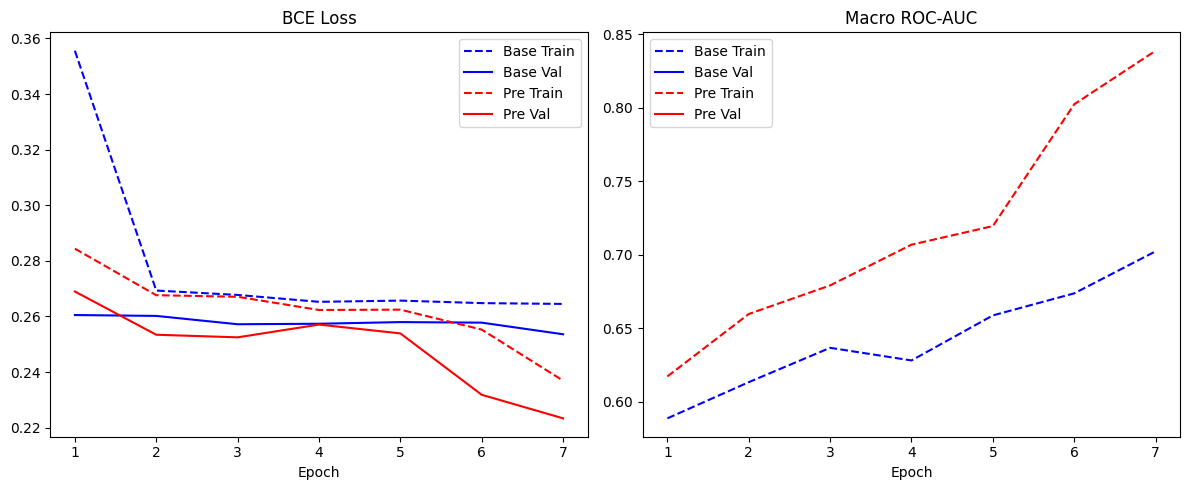

In [ ]:
# Cell 8: Plot Loss & AUC Curves
eps = list(range(1, E2+1))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(eps, hist['base']['train_loss'], 'b--', label='Base Train')
plt.plot(eps, hist['base']['val_loss'],   'b-',  label='Base Val')
plt.plot(eps, hist['pre']['train_loss'],  'r--', label='Pre Train')
plt.plot(eps, hist['pre']['val_loss'],    'r-',  label='Pre Val')
plt.title("BCE Loss"); plt.xlabel("Epoch"); plt.legend()

plt.subplot(1,2,2)
plt.plot(eps, hist['base']['train_auc'], 'b--', label='Base Train')
plt.plot(eps, hist['base']['val_auc'],   'b-',  label='Base Val')
plt.plot(eps, hist['pre']['train_auc'],  'r--', label='Pre Train')
plt.plot(eps, hist['pre']['val_auc'],    'r-',  label='Pre Val')
plt.title("Macro ROC-AUC"); plt.xlabel("Epoch"); plt.legend()

plt.tight_layout(); plt.show()

In [ ]:
# Cell 9: Comprehensive Evaluation on Val Set
# 1) Gather y_true, y_pred_probs
pre_model.eval(); base_model.eval()
y_true, y_pred_prob = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        y_true.append(yb.numpy())
        y_pred_prob.append(torch.sigmoid(pre_model(xb)).cpu().numpy())
y_true = np.vstack(y_true)
y_prob = np.vstack(y_pred_prob)
y_pred = (y_prob >= 0.5).astype(int)

# 2) Metrics
acc_subset = accuracy_score(y_true, y_pred)            # exact-match
hamming    = hamming_loss(y_true, y_pred)
jaccard    = jaccard_score(y_true, y_pred, average='samples')
prec_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
rec_micro  = recall_score(   y_true, y_pred, average='micro', zero_division=0)
f1_micro   = f1_score(       y_true, y_pred, average='micro', zero_division=0)
prec_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec_macro  = recall_score(   y_true, y_pred, average='macro', zero_division=0)
f1_macro   = f1_score(       y_true, y_pred, average='macro', zero_division=0)
roc_auc    = roc_auc_score(  y_true, y_prob, average='macro')
pr_auc     = average_precision_score(y_true, y_prob, average='macro')

print("🔎 Val Set Metrics (Pretrained Model)")
print(f"Subset Accuracy: {acc_subset:.3f}")
print(f"Hamming Loss:     {hamming:.3f}")
print(f"Jaccard:          {jaccard:.3f}")
print(f"Precision Micro:  {prec_micro:.3f}")
print(f"Recall Micro:     {rec_micro:.3f}")
print(f"F1 Micro:         {f1_micro:.3f}")
print(f"Precision Macro:  {prec_macro:.3f}")
print(f"Recall Macro:     {rec_macro:.3f}")
print(f"F1 Macro:         {f1_macro:.3f}")
print(f"ROC-AUC Macro:    {roc_auc:.3f}")
print(f"PR-AUC Macro:     {pr_auc:.3f}")

🔎 Val Set Metrics (Pretrained Model)
Subset Accuracy: 0.281
Hamming Loss:     0.091
Jaccard:          0.415
Precision Micro:  0.620
Recall Micro:     0.411
F1 Micro:         0.494
Precision Macro:  0.249
Recall Macro:     0.140
F1 Macro:         0.159
ROC-AUC Macro:    nan
PR-AUC Macro:     0.319


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


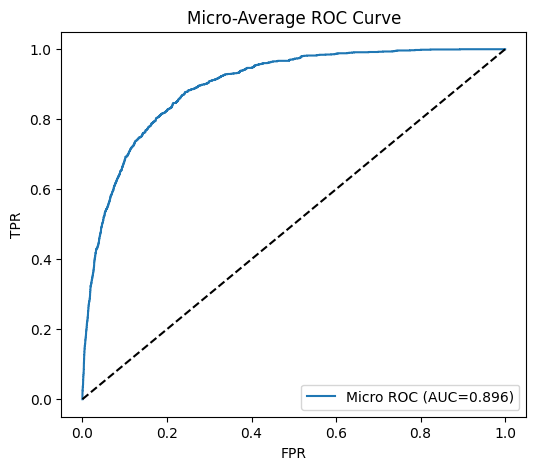

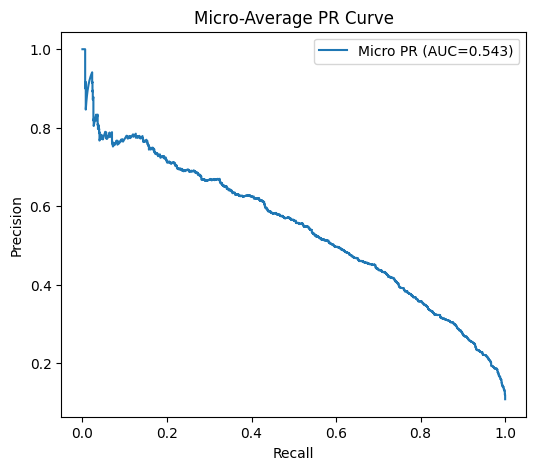

In [ ]:
# Cell 10: ROC & PR Curves (micro-average)
fpr, tpr, _ = roc_curve(y_true.ravel(), y_prob.ravel())
roc_auc_ma  = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Micro ROC (AUC={roc_auc_ma:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("Micro-Average ROC Curve")
plt.legend(); plt.show()

precision, recall, _ = precision_recall_curve(y_true.ravel(), y_prob.ravel())
pr_auc_ma = auc(recall, precision)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"Micro PR (AUC={pr_auc_ma:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Micro-Average PR Curve")
plt.legend(); plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


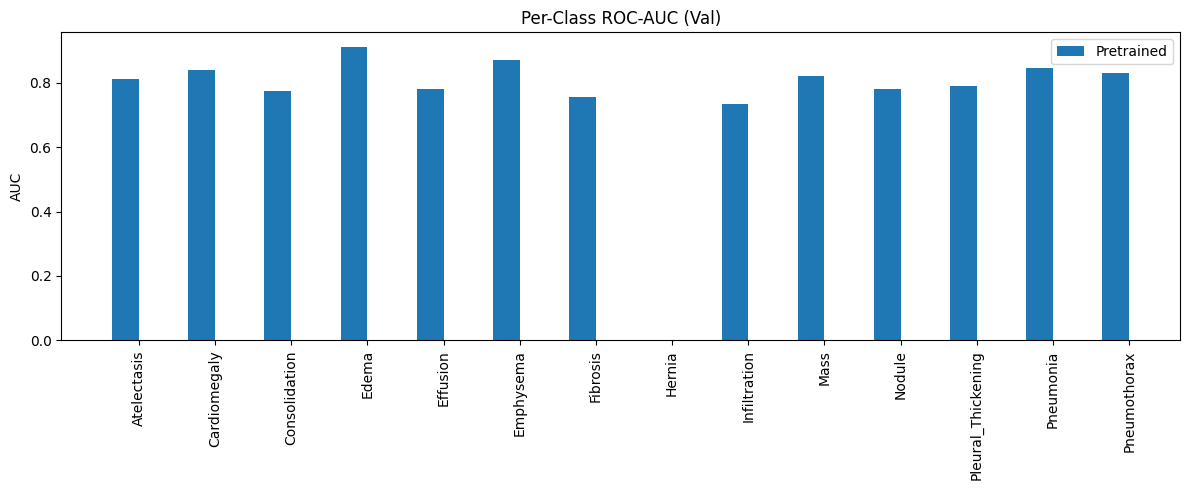

In [ ]:
# Cell 11: Per-Class AUC Bar Chart
per_auc = roc_auc_score(y_true, y_prob, average=None)
labels  = mlb.classes_
x = np.arange(len(labels)); w = 0.35

plt.figure(figsize=(12,5))
plt.bar(x-w/2, per_auc, w, label='Pretrained')
plt.xticks(x, labels, rotation=90)
plt.ylabel("AUC"); plt.title("Per-Class ROC-AUC (Val)")
plt.legend(); plt.tight_layout(); plt.show()